In [1]:
import os
import numpy as np
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from sklearn.decomposition import PCA

from model import BendrEncoder
from model.model import Flatten

from src.data.conf.eeg_annotations import braincapture_annotations

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [2]:
import logging

# Suppress logger messages from MNE-Python
mne_logger = logging.getLogger('mne')
mne_logger.setLevel(logging.ERROR)

## Generating Latent Representations

In this notebook, we will go through the steps of loading a pretrained EEG encoder (it has been trained on more than 16.000 files!), generating latent representations, finetuning linear layers to the use case, and visualising the latent representation using principal component analysis.

We start by loading our data. We load the data to our device (cuda or cpu).


**NB: If you have not yet processed the data from the original EDF files, please consult the *braincapture_data_loader* notebook.**

In [3]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
encoder = BendrEncoder()

# Load the pretrained model
encoder.load_state_dict(deepcopy(torch.load("encoder.pt", map_location=device)))
encoder = encoder.to(device)

In [4]:
X = torch.load("X_data.pt").to(device)
y = torch.load("y_data.pt").to(device).long()

We pass the BrainCapture data through the pretrained encoder to generate smart representations of the EEG signals

In [5]:
def generate_latent_representations(data, encoder, batch_size=5):
    """ Generate latent representations for the given data using the given encoder.
    Args:
        data (np.ndarray): The data to be encoded.
        encoder (nn.Module): The encoder to be used.
        batch_size (int): The batch size to be used.
    Returns:
        np.ndarray: The latent representations of the given data.
    """
    latent_size = (1536, 4) # do not change this 
    latent = np.empty((data.shape[0], *latent_size))

    for i in tqdm(range(0, data.shape[0], batch_size)):
        latent[i:i+batch_size] = encoder(data[i:i+batch_size]).cpu().detach().numpy()

    return latent.reshape((latent.shape[0], -1))

In [6]:
latent_representations = generate_latent_representations(X, encoder)

  0%|          | 0/115 [00:00<?, ?it/s]

We visualise the latent representations using PCA. We color the data by the label of the EEG windows.

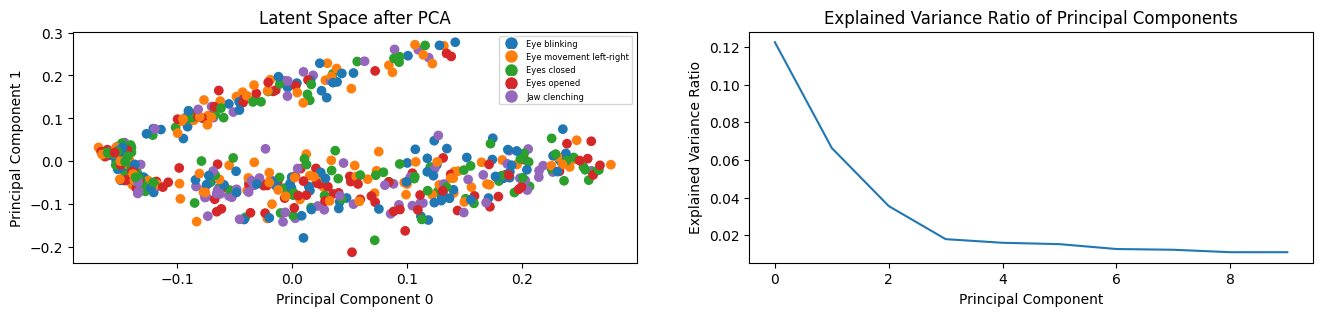

In [7]:
from src.visualisation.visualisation import plot_latent_pca

pca = PCA(n_components=10)
latent_pca = pca.fit_transform(latent_representations)

# note that you can change the first_index and second_index to any of the components
plot_latent_pca(latent_pca, y, braincapture_annotations, pca, first_index=0, second_index=1)

## Finetuning Linear Classification Layers

The EEG encoder is pretrained on 16000 EEG recordings (some another dataset) and, although it is capable of generating representations, we cannot separate the classes using PCA. For that reason, we finetune a couple of linear layers to the BrainCapture data.

In [8]:
out_features = 5

linear_head = nn.Sequential(
    encoder,
    Flatten(),
    nn.Linear(in_features = 3 * 512 * 4, out_features = 512 * 4, bias=True),
    nn.Dropout(p=0.4, inplace=False),
    nn.ReLU(),
    nn.BatchNorm1d(512 * 4),
    nn.Linear(512 * 4, out_features, bias=True) 
)

linear_head = linear_head.to(device)
linear_head = linear_head.train()

# Lock encoder parameters from training
# for param in model[0].parameters():
#     param.requires_grad = False

We set up all the necassary steps for the training loop

In [9]:
def finetune_model(model, train_loader, criterion, optimizer, scheduler, n_epochs, device):

    for epoch in range(1, n_epochs + 1):
        total = correct = 0
        pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch}, train")
        for batch in train_loader:
            if len(batch[0]) < 2: continue            
            
            optimizer.zero_grad()
                    
            X, y = batch
            X, y = X.to(device), y.to(device)
            logits = model(X)       
            _, predicted = torch.max(logits.data, 1)

            total += y.size(0)
            correct += (predicted == y).sum().item()
            
            loss = criterion(logits, y)
            loss.backward()

            optimizer.step()
            scheduler.step()
            
            pbar.update(1)

        train_accuracy = np.round(100 * correct / total, 2)
        pbar.set_description(f"Epoch {epoch}, train accuracy: {train_accuracy}%")

def evaluate_model(model, test_loader, device, optimizer):
    with torch.no_grad():
        model.eval()
        total = correct = 0
        pbar = tqdm(total=len(test_loader), desc=f"Testing...")
        for batch in test_loader:
            if len(batch[0]) < 2: continue            
            
            optimizer.zero_grad()
                    
            X, y = batch
            X, y = X.to(device), y.to(device)

            logits = model(X)
            _, predicted = torch.max(logits.data, 1)

            total += y.size(0)
            correct += (predicted == y).sum().item()
            pbar.update(1)
            
        pbar.set_description(f"Test accuracy: {100 * correct / total:2f}%") 

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X, y)

batch_size = 4
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

learning_rate = 0.0001
n_epochs = 1 # you can increase this number

optimizer = torch.optim.SGD(linear_head.parameters(), lr=learning_rate, weight_decay=0.01, momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=learning_rate, epochs=n_epochs, steps_per_epoch=len(train_loader), pct_start=0.1, last_epoch=-1
)

In [13]:
finetune_model(linear_head, train_loader, criterion, optimizer, scheduler, n_epochs, device)

Epoch 1, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 6, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 7, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 8, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 9, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 10, train:   0%|          | 0/115 [00:00<?, ?it/s]

We evaluate the model on the BrainCapture test set.

In [14]:
evaluate_model(linear_head, test_loader, device, optimizer)

Testing...:   0%|          | 0/29 [00:00<?, ?it/s]

In [15]:
finetuned_latent_representations = generate_latent_representations(X, encoder)

  0%|          | 0/115 [00:00<?, ?it/s]

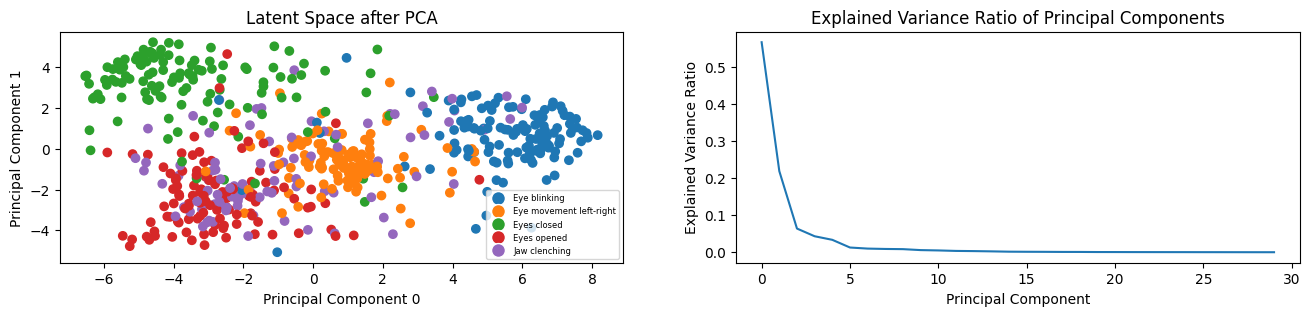

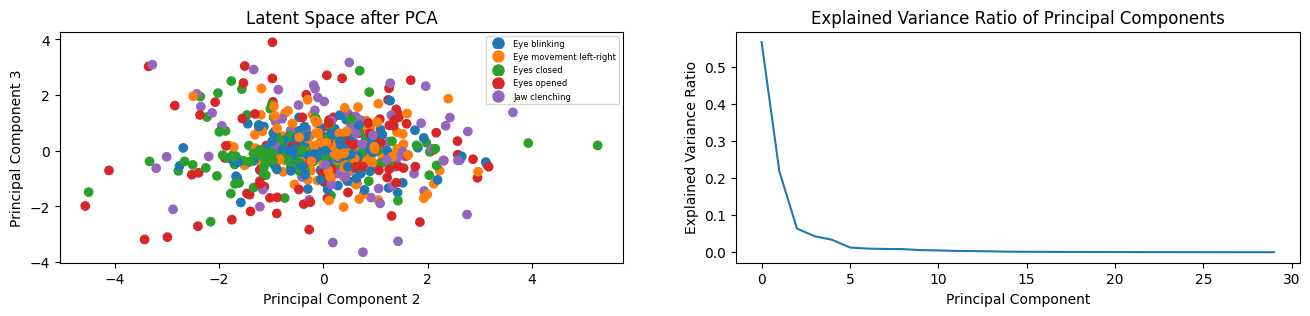

In [16]:
# Run PCA on latent
pca = PCA(n_components=30)
latent_pca = pca.fit_transform(finetuned_latent_representations)

plot_latent_pca(latent_pca, y, braincapture_annotations, pca, first_index=0, second_index=1)
plot_latent_pca(latent_pca, y, braincapture_annotations, pca, first_index=2, second_index=3)

## K-Nearest Neighbors on the Latent Representations 

A simple example of predicting artifacts using a K-Nearest Neighbors (KNN) on the PCA transformed data showcased above. 

Balanced accuracy: 0.70


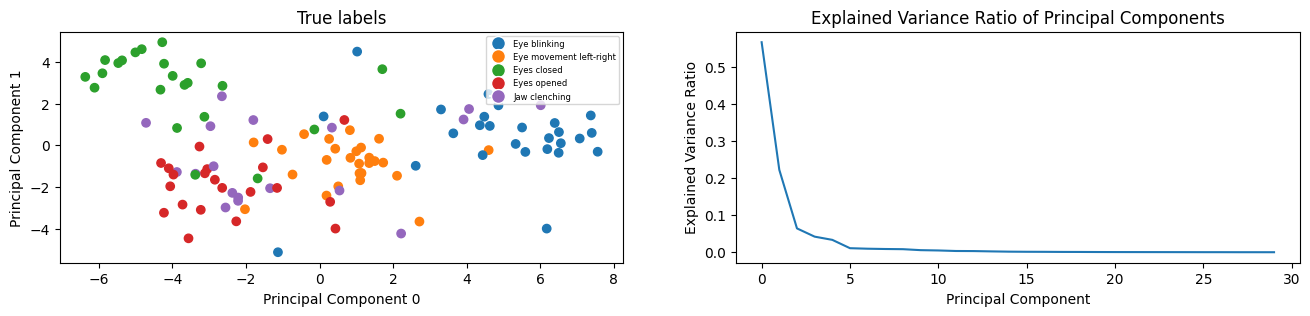

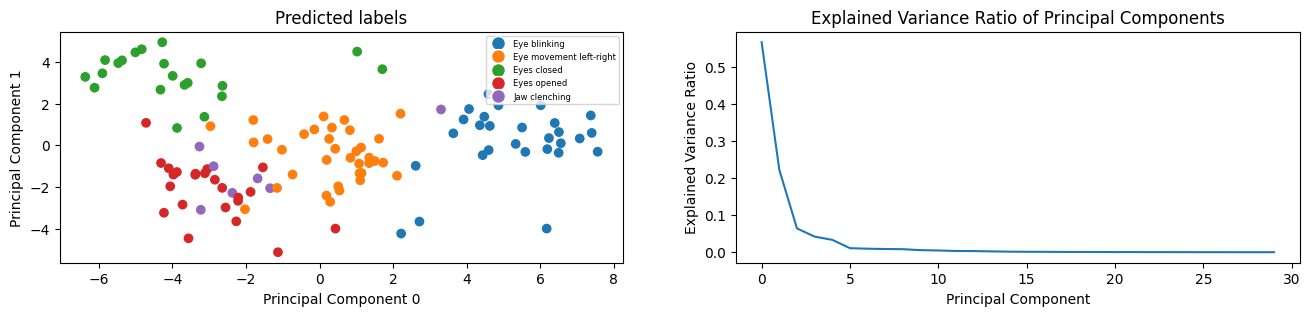

In [17]:
# split data into train and test on latent representations
X_train, X_test, y_train, y_test = train_test_split(finetuned_latent_representations, y, test_size=0.2)

# perform PCA separately on train and test data
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# train KNN classifier (predetermined number of neighbors)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train)

# evaluate the classifier
y_pred = knn.predict(X_test_pca)
y_pred = torch.tensor(y_pred, device=device)
b_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f"Balanced accuracy: {b_accuracy:.2f}")


plot_latent_pca(X_test_pca, y_test, braincapture_annotations, pca, first_index=0, second_index=1, title="True labels")
plot_latent_pca(X_test_pca, y_pred, braincapture_annotations, pca, first_index=0, second_index=1, title="Predicted labels")

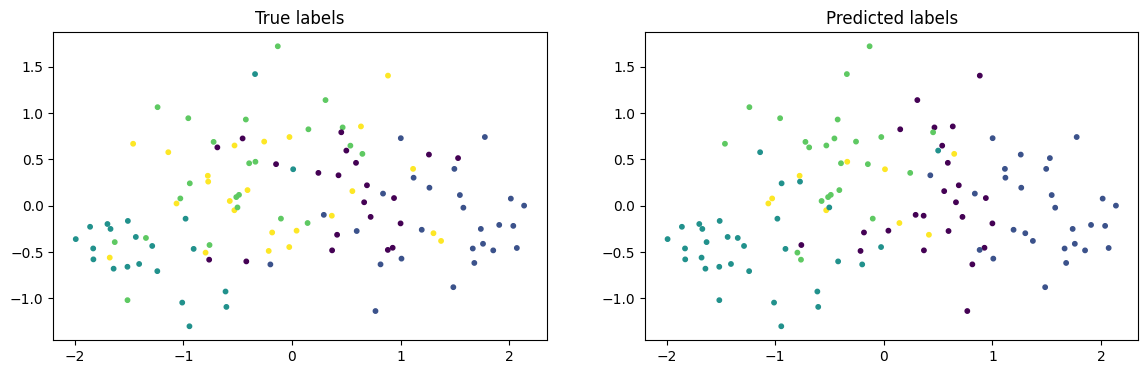

In [ ]:

# plot predictions side by side with true labels
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', s=10)
ax[0].set_title("True labels")

ax[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='viridis', s=10)
ax[1].set_title("Predicted labels")

plt.show()